Lindbald Master Equation and Hamiltonian

---

$$ \dot\rho=-i[H_{1},\rho]+\gamma_{1D}[2\sigma_{1}\rho\sigma_{1}^{\dagger}-\sigma_{1}^{\dagger}\sigma_{1}\rho-\rho\sigma_{1}^{\dagger}\sigma_{1}] $$

$$ H_{1}=[\omega_{0}+A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1}-\frac{i\Omega_{R}}{2}(e^{-i\varepsilon t}\sigma_{1}^{\dagger}-H.c) $$

Hamiltonian with Detuning



---
$$ U(t)=e^{i\epsilon t\sigma_{1}^{\dagger}\sigma_{1}} $$

$$ H_{1}^{'}=U^{\dagger}H_{1}U - iU^{\dagger}\frac{\partial U}{\partial t} $$

$$ iU^{\dagger}\frac{\partial U}{\partial t} = i(-i\epsilon)\sigma_{1}^{\dagger}\sigma_{1} = -\epsilon\sigma_{1}^{\dagger}\sigma_{1} $$

$$ U^{\dagger}(e^{-i\epsilon t}\sigma_{1}^{\dagger})U = e^{-i\epsilon t} \cdotp e^{i\epsilon t} \sigma_{1}^{\dagger} = \sigma_{1}^{\dagger}$$

$$ \delta = \omega_{0} - \epsilon $$

$$ H^{'}_{1}(t) = [\delta + A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1} - \frac{i\Omega_{R}}{2}(\sigma_{1}^{\dagger} - \sigma_{1}) $$


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import expm

%matplotlib inline

In [19]:
gamma_1D = 1.0   # Decay rate
D = 0.5          # Detuning d = (omega_0 - epsilon)
Omega = 5        # Modulation frequency
Omega_R = 0.05   # Rabi frequency
A = 0.025        # Modulation amplitude (0.025)

In [30]:
def pauli_matrices():
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    # Lowering operator (sigma_-)
    sigma = np.array([[0, 1], [0, 0]], dtype=complex)

    # Raising operator (sigma_+)
    sigma_dag = np.array([[0, 0], [1, 0]], dtype=complex)

    # Number operator
    n = sigma_dag @ sigma

    # Identity
    I = np.eye(2, dtype=complex)

    return sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I

sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I = pauli_matrices()


def A_modulation(t):
    return A * np.cos(Omega * t)


def hamiltonian(t):
    A_t = A_modulation(t)
    return (D + A_t) * n - ((1j * Omega_R) / 2) * (sigma_dag - sigma)


def commutator(A, B):
    return (A @ B) - (B @ A)


def lindblad_term(rho, s):
    s_dag = s.conj().T
    return 2 * s @ rho @ s_dag - s_dag @ s @ rho - rho @ s_dag @ s


def lindblad_master_equation(t, rho_vec):
    rho = rho_vec.reshape((2, 2))
    H = hamiltonian(t)  # Hamiltonian at time (t)
    drho_dt = (-1j * commutator(H, rho)) + (gamma_1D * lindblad_term(rho, sigma))
    return drho_dt.flatten()


def calculate_P(s):
    term1 = (s + 2 * gamma_1D)
    term2_inner = (s + gamma_1D)**2 + (Omega - D)**2
    term3 = Omega_R**2 * (s + gamma_1D)

    P_s = (term1 * term2_inner) + term3
    return P_s


def calculate_B1(s, omega_R, gamma_1D, D, Omega):
    term_1 = -1j * (omega_R / 2) * np.exp(-1j * Omega * 0)
    term_2 = s + gamma_1D * 2
    term_3 = s + gamma_1D - 1j * (Omega - D)
    P_s = calculate_P(s)

    result = term_1 * term_2 * term_3 / P_s
    return result


def calculate_B2(s, omega_R, gamma_1D, D, Omega):
    term_1 = 1j * (omega_R / 2) * np.exp(-1j * Omega * 0)
    term_2 = s + gamma_1D * 2
    term_3 = s + gamma_1D + 1j * (Omega - D)
    P_s = calculate_P(s)

    result = term_1 * term_2 * term_3 / P_s
    return result


def calculate_B3(s, gamma_1D, D, Omega):
    term_1 = -(s + gamma_1D * 2)
    term_2 = (s + gamma_1D)**2 + (Omega - D)**2
    P_s = calculate_P(s)

    result = term_1 * term_2 / P_s
    return result


# Inverse Laplace transform using numerical integration
def inverse_laplace_transform(B_func, times, omega_range, *args):
    """
    Compute inverse Laplace transform numerically using the inverse Fourier transform.
    f(t) = (1/2π) ∫ F(iω) e^(iωt) dω
    """
    s_values = 1j * omega_range
    B_values = np.array([B_func(s, *args) for s in s_values])

    # Compute inverse transform for each time point
    result = np.zeros(len(times), dtype=complex)
    dw = omega_range[1] - omega_range[0]

    for i, t in enumerate(times):
        integrand = B_values * np.exp(1j * omega_range * t)
        result[i] = np.trapz(integrand, dx=dw) / (2 * np.pi)

    return result


def calculate_correlation_function(s, omega_R, gamma_1D, D, Omega):
    """
    Laplace transform of <sigma_+(t)sigma_-(t+δt)> correlation function
    From the paper equation:
    L[e^(ikδt)<σ+(t)σ-(t+δt)>] = (R²/2) / (1 + D² + R²/2) * [P(s) - (ωR²/2)(s + γ/2)] / [sP(s)]

    Where:
    - D = (Ω - k)r is normalized detuning  → (Omega - D) in our notation
    - R = ωR*r is normalized Rabi frequency → Omega_R in our notation
    - γ/2 = gamma_1D in our notation
    """
    # Normalized parameters (assuming r=1 for simplicity)
    D_normalized = Omega - D  # Paper's D = (Ω - k)
    R_normalized = omega_R     # Paper's R = ωR

    # Prefactor
    prefactor = (0.5 * R_normalized**2) / (1 + D_normalized**2 + 0.5 * R_normalized**2)

    # P(s)
    P_s = calculate_P(s)

    # Numerator: P(s) - (ωR²/2)(s + γ/2)
    numerator = P_s - 0.5 * omega_R**2 * (s + gamma_1D)

    # Full expression
    result = prefactor * numerator / (s * P_s)

    return result

In [31]:
psi0 = np.array([1, 0], dtype=complex)  # Initial ground state, outer product
rho0 = np.outer(psi0, psi0.conj())
rho0_vec = rho0.flatten()

t_final = 6 / gamma_1D
times = np.linspace(0, t_final, 1000)

print("[*] Starting integration.")
solution = solve_ivp(
    lindblad_master_equation,
    t_span=(0, t_final),
    y0=rho0_vec,
    t_eval=times,
    method='DOP853',  # RK45
)

print("[*] Integration complete!")

# Observables from density matrix
n_expect = np.zeros(len(solution.t))
sigma_dag_expect = np.zeros(len(solution.t), dtype=complex)
sigma_expect = np.zeros(len(solution.t), dtype=complex)

for i, t in enumerate(solution.t):
    rho = solution.y[:, i].reshape((2, 2))

    # Expectation values
    n_expect[i] = np.trace(rho @ n).real  # <σ†σ> = <σ+σ->
    sigma_dag_expect[i] = np.trace(rho @ sigma_dag)
    sigma_expect[i] = np.trace(rho @ sigma)

# Compute inverse Laplace transforms for B1, B2, B3
print("[*] Computing inverse Laplace transforms...")
omega_range = np.linspace(-50, 50, 2000)  # Extended range for better accuracy

B1_time = inverse_laplace_transform(calculate_B1, times, omega_range, Omega_R, gamma_1D, D, Omega)
B2_time = inverse_laplace_transform(calculate_B2, times, omega_range, Omega_R, gamma_1D, D, Omega)
B3_time = inverse_laplace_transform(calculate_B3, times, omega_range, gamma_1D, D, Omega)

print("[*] Computing correlation function inverse Laplace transform...")
correlation_time = inverse_laplace_transform(calculate_correlation_function, times, omega_range,
                                            Omega_R, gamma_1D, D, Omega)

print("[*] All inverse Laplace transforms complete!")

[*] Starting integration.
[*] Integration complete!
[*] Computing inverse Laplace transforms...


/tmp/ipython-input-3969985990.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  result[i] = np.trapz(integrand, dx=dw) / (2 * np.pi)


[*] Computing correlation function inverse Laplace transform...
[*] All inverse Laplace transforms complete!


[*] Plot saved as correlation_comparison.png


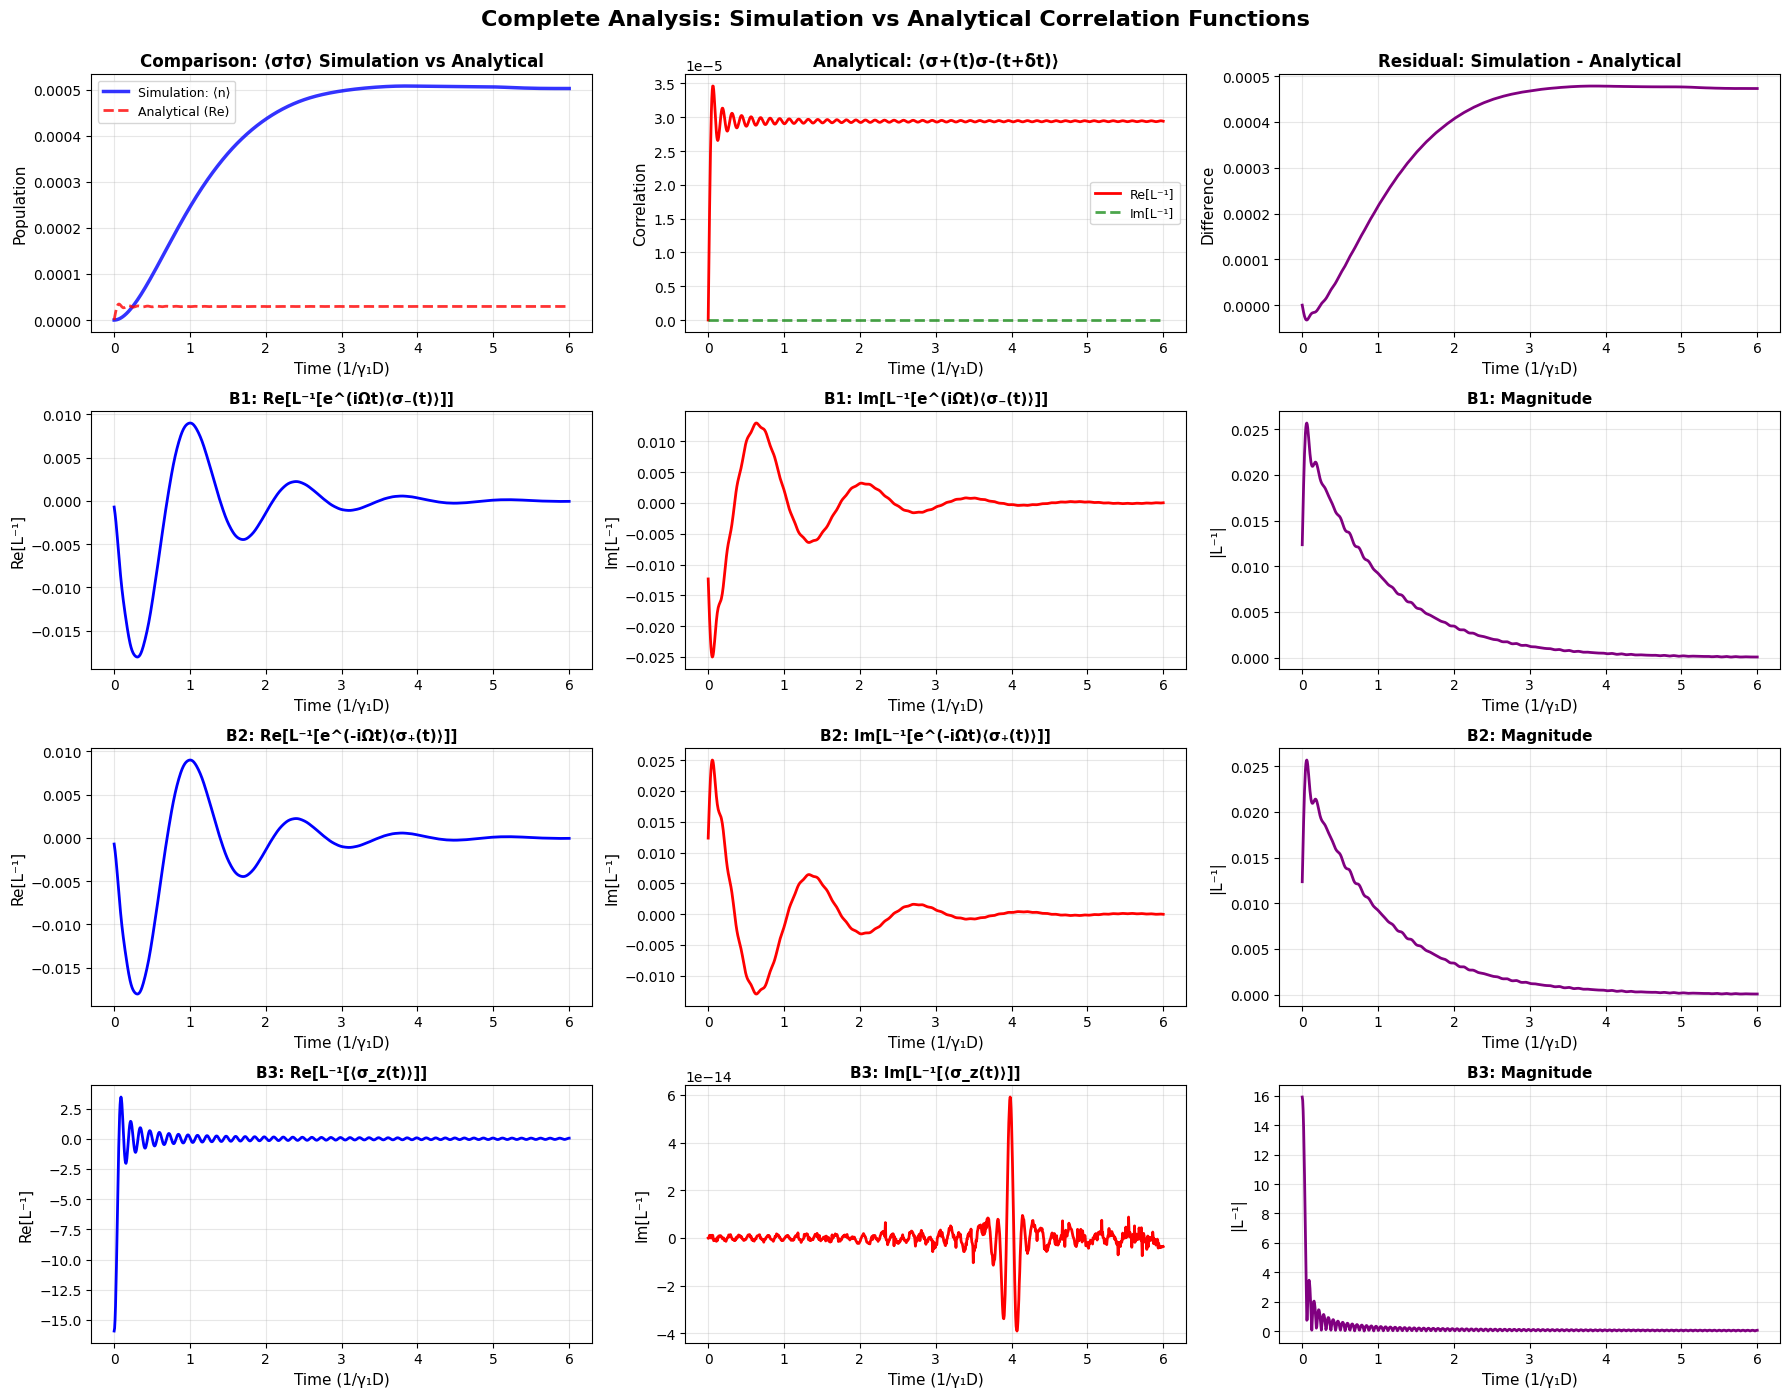


COMPARISON STATISTICS
Simulation ⟨n⟩ (final):      0.000502
Analytical Re[corr] (final):  0.000029
Analytical Im[corr] (final):  -0.000000
Difference (final):           0.000473
Mean absolute error:          0.000380
Max absolute error:           0.000478
RMS error:                    0.000407


In [32]:
# Create comprehensive comparison plots
fig = plt.figure(figsize=(18, 14))

# ===== ROW 1: Population comparison =====
ax1 = plt.subplot(4, 3, 1)
ax1.plot(times, n_expect, 'b-', linewidth=2.5, label='Simulation: ⟨n⟩', alpha=0.8)
ax1.plot(times, correlation_time.real, 'r--', linewidth=2, label='Analytical (Re)', alpha=0.8)
ax1.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax1.set_ylabel('Population', fontsize=11)
ax1.set_title('Comparison: ⟨σ†σ⟩ Simulation vs Analytical', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(4, 3, 2)
ax2.plot(times, correlation_time.real, 'r-', linewidth=2, label='Re[L⁻¹]')
ax2.plot(times, correlation_time.imag, 'g--', linewidth=2, label='Im[L⁻¹]', alpha=0.7)
ax2.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax2.set_ylabel('Correlation', fontsize=11)
ax2.set_title('Analytical: ⟨σ+(t)σ-(t+δt)⟩', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(4, 3, 3)
difference = n_expect - correlation_time.real
ax3.plot(times, difference, 'purple', linewidth=2)
ax3.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax3.set_ylabel('Difference', fontsize=11)
ax3.set_title('Residual: Simulation - Analytical', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# ===== ROW 2: B1 results =====
ax4 = plt.subplot(4, 3, 4)
ax4.plot(times, B1_time.real, 'b-', linewidth=2)
ax4.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax4.set_ylabel('Re[L⁻¹]', fontsize=11)
ax4.set_title('B1: Re[L⁻¹[e^(iΩt)⟨σ₋(t)⟩]]', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(4, 3, 5)
ax5.plot(times, B1_time.imag, 'r-', linewidth=2)
ax5.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax5.set_ylabel('Im[L⁻¹]', fontsize=11)
ax5.set_title('B1: Im[L⁻¹[e^(iΩt)⟨σ₋(t)⟩]]', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(4, 3, 6)
ax6.plot(times, np.abs(B1_time), 'purple', linewidth=2)
ax6.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax6.set_ylabel('|L⁻¹|', fontsize=11)
ax6.set_title('B1: Magnitude', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3)

# ===== ROW 3: B2 results =====
ax7 = plt.subplot(4, 3, 7)
ax7.plot(times, B2_time.real, 'b-', linewidth=2)
ax7.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax7.set_ylabel('Re[L⁻¹]', fontsize=11)
ax7.set_title('B2: Re[L⁻¹[e^(-iΩt)⟨σ₊(t)⟩]]', fontsize=11, fontweight='bold')
ax7.grid(True, alpha=0.3)

ax8 = plt.subplot(4, 3, 8)
ax8.plot(times, B2_time.imag, 'r-', linewidth=2)
ax8.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax8.set_ylabel('Im[L⁻¹]', fontsize=11)
ax8.set_title('B2: Im[L⁻¹[e^(-iΩt)⟨σ₊(t)⟩]]', fontsize=11, fontweight='bold')
ax8.grid(True, alpha=0.3)

ax9 = plt.subplot(4, 3, 9)
ax9.plot(times, np.abs(B2_time), 'purple', linewidth=2)
ax9.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax9.set_ylabel('|L⁻¹|', fontsize=11)
ax9.set_title('B2: Magnitude', fontsize=11, fontweight='bold')
ax9.grid(True, alpha=0.3)

# ===== ROW 4: B3 results =====
ax10 = plt.subplot(4, 3, 10)
ax10.plot(times, B3_time.real, 'b-', linewidth=2)
ax10.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax10.set_ylabel('Re[L⁻¹]', fontsize=11)
ax10.set_title('B3: Re[L⁻¹[⟨σ_z(t)⟩]]', fontsize=11, fontweight='bold')
ax10.grid(True, alpha=0.3)

ax11 = plt.subplot(4, 3, 11)
ax11.plot(times, B3_time.imag, 'r-', linewidth=2)
ax11.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax11.set_ylabel('Im[L⁻¹]', fontsize=11)
ax11.set_title('B3: Im[L⁻¹[⟨σ_z(t)⟩]]', fontsize=11, fontweight='bold')
ax11.grid(True, alpha=0.3)

ax12 = plt.subplot(4, 3, 12)
ax12.plot(times, np.abs(B3_time), 'purple', linewidth=2)
ax12.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax12.set_ylabel('|L⁻¹|', fontsize=11)
ax12.set_title('B3: Magnitude', fontsize=11, fontweight='bold')
ax12.grid(True, alpha=0.3)

plt.suptitle('Complete Analysis: Simulation vs Analytical Correlation Functions',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('correlation_comparison.png', dpi=300, bbox_inches='tight')
print("[*] Plot saved as correlation_comparison.png")
plt.show()

# Print comparison statistics
print("\n" + "="*60)
print("COMPARISON STATISTICS")
print("="*60)
print(f"Simulation ⟨n⟩ (final):      {n_expect[-1]:.6f}")
print(f"Analytical Re[corr] (final):  {correlation_time.real[-1]:.6f}")
print(f"Analytical Im[corr] (final):  {correlation_time.imag[-1]:.6f}")
print(f"Difference (final):           {difference[-1]:.6f}")
print(f"Mean absolute error:          {np.mean(np.abs(difference)):.6f}")
print(f"Max absolute error:           {np.max(np.abs(difference)):.6f}")
print(f"RMS error:                    {np.sqrt(np.mean(difference**2)):.6f}")
print("="*60)

In [15]:
for i in range(len(n_expect)):
    print(f"{n_expect[i]} | {correlation_time.real[i]}")

0.0 | 8.647616099099613e-10
2.241011621949407e-08 | 5.595293815926489e-06
8.91042773135595e-08 | 1.1022979255637624e-05
1.992862832099149e-07 | 1.6126129423060286e-05
3.521706048133653e-07 | 2.0764281922072143e-05
5.469822597398481e-07 | 2.4821577823108034e-05
7.829567245025296e-07 | 2.8212475941753528e-05
1.0593396806706363e-06 | 3.088555965786211e-05
1.3753869726645195e-06 | 3.282522017356888e-05
1.7303645121248116e-06 | 3.405114539612961e-05
2.1235481511098068e-06 | 3.461569226346748e-05
2.5542235576664115e-06 | 3.459936162875349e-05
3.021686093703259e-06 | 3.410471873851278e-05
3.5252406950945916e-06 | 3.324920020544444e-05
4.064201753943523e-06 | 3.215731353150102e-05
4.637893002933268e-06 | 3.0952763505381413e-05
5.245647401694928e-06 | 2.9751029779536954e-05
5.886807025120486e-06 | 2.8652873065485856e-05
6.560722953549531e-06 | 2.7739167809482706e-05
7.266755164758394e-06 | 2.7067353407358405e-05
8.004272427680243e-06 | 2.6669672295243335e-05
8.772652197784736e-06 | 2.6553231087